# Train Detectron2 with Custom COCO Datasets

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import gdown
import torch

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Register your own data set in coco format

from detectron2.data.datasets import register_coco_instances

register_coco_instances('subt_train', {}, 
                        '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_train.json', 
                       '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_train')
register_coco_instances('subt_val', {}, 
                        '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_val.json', 
                       '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_val')

In [2]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances('mini_train', {}, 
                        '/home/arg/detectron2/datasets/mini_competition_dataset/train.json', 
                       '/home/arg/detectron2/datasets/mini_competition_dataset/image')
register_coco_instances('mini_val', {}, 
                        '/home/arg/detectron2/datasets/mini_competition_dataset/val.json', 
                       '/home/arg/detectron2/datasets/mini_competition_dataset/image')

In [3]:
subt_metadata = MetadataCatalog.get("mini_train")
dataset_dicts = DatasetCatalog.get("mini_train")
subt_metadata



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Metadata(evaluator_type='coco', image_root='/home/arg/detectron2/datasets/mini_competition_dataset/image', json_file='/home/arg/detectron2/datasets/mini_competition_dataset/train.json', name='mini_train', thing_classes=['kusan', 'doublemint', 'kinder'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2})

## Visualize dataset - make sure the data is loaded without problems

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset.

KeyboardInterrupt: 

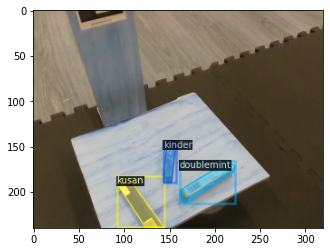

In [6]:
import random

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=subt_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1], cmap='nipy_spectral')
    cv2.waitKey(0)

## Change configuration parameters
Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the dataset.

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("mini_train",)
cfg.DATASETS.TEST = ("mini_val", )
cfg.DATALOADER.NUM_WORKERS = 0 #Single thread
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # datasets classes
cfg.SOLVER.IMS_PER_BATCH = 4 #Batch size
ITERS_IN_ONE_EPOCH = 669//4 #610 #dataset_imgs/batch_size  
cfg.SOLVER.MAX_ITER = (ITERS_IN_ONE_EPOCH * 50) # ITERS = 8k3

cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.CHECKPOINT_PERIOD = ITERS_IN_ONE_EPOCH #Save training model interval


## Training


In [8]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(False)
trainer.train()

[07/03 16:19:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [07/03 16:19:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/03 16:19:38 d2.data.datasets.coco]: Loaded 669 images in COCO format from /home/arg/detectron2/datasets/mini_competition_dataset/train.json
[07/03 16:19:38 d2.data.build]: Removed 0 images with no usable annotations. 669 images left.
[07/03 16:19:38 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   kusan    | 669          | doublemint | 669          |   kinder   | 669          |
|            |              |            |              |            |              |
|   total    | 2007         |            |              |            |              |
[07/03 16:19:38 d2.data.common]: Serializing 669 elements to byte tensors and concatenating them all ...
[07/03 

model_final_f10217.pkl: 178MB [00:16, 10.6MB/s]                              
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (3,) in the model!


[07/03 16:19:55 d2.engine.train_loop]: Starting training from iteration 0
[07/03 16:20:06 d2.utils.events]:  eta: 1:15:19  iter: 19  total_loss: 3.120  loss_cls: 1.527  loss_box_reg: 0.875  loss_mask: 0.691  loss_rpn_cls: 0.017  loss_rpn_loc: 0.008  time: 0.5509  data_time: 0.0603  lr: 0.000005  max_mem: 4141M
[07/03 16:20:17 d2.utils.events]:  eta: 1:15:08  iter: 39  total_loss: 3.000  loss_cls: 1.407  loss_box_reg: 0.891  loss_mask: 0.684  loss_rpn_cls: 0.013  loss_rpn_loc: 0.008  time: 0.5460  data_time: 0.0596  lr: 0.000010  max_mem: 4141M
[07/03 16:20:28 d2.utils.events]:  eta: 1:15:36  iter: 59  total_loss: 2.792  loss_cls: 1.179  loss_box_reg: 0.874  loss_mask: 0.666  loss_rpn_cls: 0.016  loss_rpn_loc: 0.008  time: 0.5462  data_time: 0.0606  lr: 0.000015  max_mem: 4141M
[07/03 16:20:39 d2.utils.events]:  eta: 1:15:25  iter: 79  total_loss: 2.510  loss_cls: 0.923  loss_box_reg: 0.887  loss_mask: 0.645  loss_rpn_cls: 0.014  loss_rpn_loc: 0.009  time: 0.5480  data_time: 0.0603  lr:

[07/03 16:26:19 d2.utils.events]:  eta: 1:11:30  iter: 679  total_loss: 0.380  loss_cls: 0.076  loss_box_reg: 0.189  loss_mask: 0.103  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.5609  data_time: 0.0603  lr: 0.000170  max_mem: 4141M
[07/03 16:26:30 d2.utils.events]:  eta: 1:11:20  iter: 699  total_loss: 0.384  loss_cls: 0.082  loss_box_reg: 0.184  loss_mask: 0.103  loss_rpn_cls: 0.001  loss_rpn_loc: 0.007  time: 0.5608  data_time: 0.0604  lr: 0.000175  max_mem: 4141M
[07/03 16:26:41 d2.utils.events]:  eta: 1:11:09  iter: 719  total_loss: 0.361  loss_cls: 0.071  loss_box_reg: 0.190  loss_mask: 0.104  loss_rpn_cls: 0.000  loss_rpn_loc: 0.008  time: 0.5607  data_time: 0.0599  lr: 0.000180  max_mem: 4141M
[07/03 16:26:52 d2.utils.events]:  eta: 1:10:58  iter: 739  total_loss: 0.345  loss_cls: 0.065  loss_box_reg: 0.172  loss_mask: 0.098  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  time: 0.5606  data_time: 0.0623  lr: 0.000185  max_mem: 4141M
[07/03 16:27:05 d2.utils.events]:  eta: 1:10

[07/03 16:32:31 d2.utils.events]:  eta: 1:05:21  iter: 1339  total_loss: 0.293  loss_cls: 0.041  loss_box_reg: 0.149  loss_mask: 0.100  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  time: 0.5606  data_time: 0.0613  lr: 0.000250  max_mem: 4141M
[07/03 16:32:43 d2.utils.events]:  eta: 1:05:09  iter: 1359  total_loss: 0.286  loss_cls: 0.043  loss_box_reg: 0.147  loss_mask: 0.093  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.5610  data_time: 0.0616  lr: 0.000250  max_mem: 4141M
[07/03 16:32:54 d2.utils.events]:  eta: 1:04:59  iter: 1379  total_loss: 0.306  loss_cls: 0.041  loss_box_reg: 0.144  loss_mask: 0.093  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.5611  data_time: 0.0607  lr: 0.000250  max_mem: 4141M
[07/03 16:33:06 d2.utils.events]:  eta: 1:04:46  iter: 1399  total_loss: 0.327  loss_cls: 0.045  loss_box_reg: 0.149  loss_mask: 0.105  loss_rpn_cls: 0.000  loss_rpn_loc: 0.007  time: 0.5613  data_time: 0.0604  lr: 0.000250  max_mem: 4141M
[07/03 16:33:17 d2.utils.events]:  eta: 

[07/03 16:38:41 d2.utils.events]:  eta: 0:58:55  iter: 1999  total_loss: 0.264  loss_cls: 0.039  loss_box_reg: 0.134  loss_mask: 0.084  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.5598  data_time: 0.0590  lr: 0.000250  max_mem: 4141M
[07/03 16:38:52 d2.utils.events]:  eta: 0:58:43  iter: 2019  total_loss: 0.264  loss_cls: 0.036  loss_box_reg: 0.132  loss_mask: 0.086  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.5596  data_time: 0.0592  lr: 0.000250  max_mem: 4141M
[07/03 16:39:03 d2.utils.events]:  eta: 0:58:32  iter: 2039  total_loss: 0.283  loss_cls: 0.039  loss_box_reg: 0.144  loss_mask: 0.091  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  time: 0.5594  data_time: 0.0606  lr: 0.000250  max_mem: 4141M
[07/03 16:39:14 d2.utils.events]:  eta: 0:58:20  iter: 2059  total_loss: 0.266  loss_cls: 0.035  loss_box_reg: 0.130  loss_mask: 0.094  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.5592  data_time: 0.0607  lr: 0.000250  max_mem: 4141M
[07/03 16:39:25 d2.utils.events]:  eta: 

[07/03 16:44:52 d2.utils.events]:  eta: 0:52:45  iter: 2659  total_loss: 0.265  loss_cls: 0.047  loss_box_reg: 0.135  loss_mask: 0.089  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  time: 0.5594  data_time: 0.0615  lr: 0.000250  max_mem: 4141M
[07/03 16:45:03 d2.utils.events]:  eta: 0:52:33  iter: 2679  total_loss: 0.269  loss_cls: 0.032  loss_box_reg: 0.139  loss_mask: 0.086  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  time: 0.5593  data_time: 0.0600  lr: 0.000250  max_mem: 4141M
[07/03 16:45:14 d2.utils.events]:  eta: 0:52:23  iter: 2699  total_loss: 0.243  loss_cls: 0.036  loss_box_reg: 0.124  loss_mask: 0.082  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.5592  data_time: 0.0598  lr: 0.000250  max_mem: 4141M
[07/03 16:45:25 d2.utils.events]:  eta: 0:52:12  iter: 2719  total_loss: 0.256  loss_cls: 0.031  loss_box_reg: 0.130  loss_mask: 0.089  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.5593  data_time: 0.0603  lr: 0.000250  max_mem: 4141M
[07/03 16:45:37 d2.utils.events]:  eta: 

[07/03 16:51:07 d2.utils.events]:  eta: 0:46:53  iter: 3319  total_loss: 0.281  loss_cls: 0.044  loss_box_reg: 0.141  loss_mask: 0.092  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.5603  data_time: 0.0600  lr: 0.000250  max_mem: 4141M
[07/03 16:51:18 d2.utils.events]:  eta: 0:46:44  iter: 3339  total_loss: 0.263  loss_cls: 0.032  loss_box_reg: 0.127  loss_mask: 0.085  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.5603  data_time: 0.0599  lr: 0.000250  max_mem: 4141M
[07/03 16:51:29 d2.utils.events]:  eta: 0:46:30  iter: 3359  total_loss: 0.256  loss_cls: 0.038  loss_box_reg: 0.125  loss_mask: 0.087  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.5602  data_time: 0.0647  lr: 0.000250  max_mem: 4141M
[07/03 16:51:40 d2.utils.events]:  eta: 0:46:21  iter: 3379  total_loss: 0.243  loss_cls: 0.036  loss_box_reg: 0.116  loss_mask: 0.080  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.5602  data_time: 0.0642  lr: 0.000250  max_mem: 4141M
[07/03 16:51:52 d2.utils.events]:  eta: 

KeyboardInterrupt: 

## Make a prediction

Download a pre-trained SubT model

models_url = "https://drive.google.com/a/g2.nctu.edu.tw/uc?id=1LjW4-4YAL81TXkxL9tzm0NaiOhuJVpNg&export=download"
models_name = "model_0096989.pth"
if not os.path.isfile("output/" + models_name):
    gdown.download(models_url, output="output/" + models_name, quiet=False)

print("Finished downloading models.") 

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0003673.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("mini_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.


{'instances': Instances(num_instances=3, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([[253.0650, 317.2037, 327.6716, 448.5427],
        [429.3960, 312.5035, 560.1281, 427.7720],
        [387.7726, 407.6431, 499.5530, 477.9276]], device='cuda:0')), scores: tensor([0.9986, 0.9986, 0.9962], device='cuda:0'), pred_classes: tensor([1, 0, 2], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, Fa

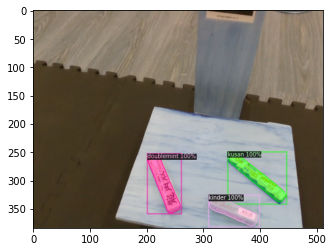

In [17]:
from detectron2.utils.visualizer import ColorMode
import random

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=subt_metadata, 
                   scale=0.8, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1], cmap='nipy_spectral')